# Phishing Model Prototype

In [1]:
%pip install numpy
%pip install pandas
%pip install joblib
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install scipy
%pip install jupyter
%pip install nltk
%pip install num2words
%pip install spacy
!python -m spacy download en_core_web_sm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------------- ------- 10.2/12.8 MB 53.9 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 47.6 MB/s  0:00:00
✔ Download and installation successful
You c

In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import num2words

import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Data

In [3]:
data = "./data/Nazario_Full.csv"

emails = pd.read_csv(data, sep=",", encoding="UTF-8")

df_emails = emails.copy()

df_emails.shape

(1565, 6)

In [4]:
df_emails.sample(5)

,sender,receiver,date,subject,body,urls
1086,monkey.org <young.86@kabel-deutschland.de>,jose@monkey.org,11 Sep 2019 07:42:07 -0700,jose@monkey.org Messages could not be delivered.,Some email Messages could not be deliveredTher...,1
1169,monkey.org <tan.dn@starseed.fr>,jose@monkey.org,27 Feb 2020 09:28:08 +0100,jose@monkey.org have stopped processing incomi...,We have stopped processing incoming emails You...,1
381,postmasetr@nibiru.b-link.it <notifications@nib...,jose@monkey.org,1 Nov 2016 04:44:08 +0100,Alert,"This is an automated email, please do not repl...",1
180,"""Bushell, Lynda"" <lybushell@mcalester.k12.ok.us>","""info@tecumsehalumni.org"" <info@tecumsehalumni...","Tue, 29 Mar 2016 23:20:31 +0000",Your mailbox is almost full,To keep your password active. Click Here to up...,1
748,"""Drop Box "" <service@filesafe.com>",jose@monkey.org,"Sat, 24 Mar 2018 03:37:32 -0700",Someone sent you some file (jose@monkey.org),"Dear jose@monkey.org, You have received 3 file...",1


In [5]:
df_emails.dtypes

sender      object
receiver    object
date        object
subject     object
body        object
urls         int64
dtype: object

## 2. Data Understanding

In [6]:
df_emails.describe()

,urls
count,1565.000000
mean,0.909265
std,0.287323
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


### Emptyness

In [7]:
df_percentages = (100*df_emails.isna().sum()/len(df_emails)).to_frame()
df_percentages.sort_values(0, ascending = False)

,0
receiver,6.134185
subject,0.255591
date,0.063898
sender,0.000000
body,0.000000
urls,0.000000


### Duplicates

In [8]:
df_duplicated = df_emails.loc[df_emails.duplicated(keep=False)]
df_duplicated

,sender,receiver,date,subject,body,urls


## 3. Data Transformations

### Drop Empty & Duplicates

In [9]:
def drop_empty(dataframe):

    dataframe.dropna(inplace=True)

    return

drop_empty(df_emails)

df_emails.shape

(1467, 6)

In [10]:
def drop_duplicates(dataframe):

    dataframe.drop_duplicates(inplace=True)

    return

drop_duplicates(df_emails)
df_emails.shape

(1467, 6)

### Drop Unnecesarry Columns

In [11]:
#df_emails.drop(columns=["date", "urls"], inplace=True)
df_emails.drop(columns=["date"], inplace=True)

### Data Cleaning

In [12]:
def clean_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["body"] = df_emails["body"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)

    return

def clean_upper_case(df_emails):
    df_emails["sender"] = df_emails["sender"].str.lower()
    df_emails["receiver"] = df_emails["receiver"].str.lower()
    df_emails["subject"] = df_emails["subject"].str.lower()
    df_emails["body"] = df_emails["body"].str.lower()

    return

def clean_punctuation(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))

    return

def clean_numbers(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))

    return

def clena_stopwords(df_emails):
    stop_words = set(stopwords.words('english'))

    df_emails["sender"] = df_emails["sender"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["body"] = df_emails["body"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return

def clean_sidebar(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.replace("-", " "))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.replace("-", " "))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.replace("-", " "))
    df_emails["body"] = df_emails["body"].apply(lambda x: x.replace("-", " "))

    return

numbers_post_ascii = r'[0123456789]'

def clean_numbers_post_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(numbers_post_ascii, '', x))

    return


In [13]:
def clean_text(df_emails):

    clean_ascii(df_emails)
    clean_upper_case(df_emails)
    clean_punctuation(df_emails)
    clean_numbers(df_emails)
    clena_stopwords(df_emails)
    clean_sidebar(df_emails)
    clean_numbers_post_ascii(df_emails)

    return

clean_text(df_emails)
print(df_emails)

                                                 sender  \
1                               cpanel servicecpanelcom   
3                            ann garcia angarciamcoeorg   
4                           usaa usaaacctupdatesccuucom   
5                              utf qpesupport infospcom   
6                                                update   
...                                                 ...   
1560  info advantageapartmentscom infoadvantageapart...   
1561                        monkeyorg helpdeskmonkeyorg   
1562  help center infohelp centercozainfohelp center...   
1563                          metamask infosofamekarcom   
1564  fastway infofastwaycozainfofastwaycozainfofast...   

                               receiver  \
1                         josemonkeyorg   
3           infomaaaaaorg infomaaaaaorg   
4     recipients usaaacctupdatesccuucom   
5                         josemonkeyorg   
6                            recipients   
...                              

### Bag Of Words

In [14]:
def tokenize_text(df_emails):

    df_emails["sender_T"] = df_emails["sender"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["receiver_T"] = df_emails["receiver"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["subject_T"] = df_emails["subject"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["body_T"] = df_emails["body"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])

    return

tokenize_text(df_emails)
print(df_emails)

                                                 sender  \
1                               cpanel servicecpanelcom   
3                            ann garcia angarciamcoeorg   
4                           usaa usaaacctupdatesccuucom   
5                              utf qpesupport infospcom   
6                                                update   
...                                                 ...   
1560  info advantageapartmentscom infoadvantageapart...   
1561                        monkeyorg helpdeskmonkeyorg   
1562  help center infohelp centercozainfohelp center...   
1563                          metamask infosofamekarcom   
1564  fastway infofastwaycozainfofastwaycozainfofast...   

                               receiver  \
1                         josemonkeyorg   
3           infomaaaaaorg infomaaaaaorg   
4     recipients usaaacctupdatesccuucom   
5                         josemonkeyorg   
6                            recipients   
...                              

In [15]:
vectorizer = CountVectorizer()

def vectorize_tokens(df_emails):

    global vectorizer

    email_plain_text = df_emails['sender_T'].astype('str') + ""  + df_emails['receiver_T'].astype('str') + " " + df_emails['subject_T'].astype('str') + " " + df_emails['body_T'].astype('str')

    df_vectorized = vectorizer.fit_transform(email_plain_text)

    return df_vectorized

vectorization = vectorize_tokens(df_emails)
print(vectorization)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 111597 stored elements and shape (1467, 38536)>
  Coords	Values
  (0, 4652)	2
  (0, 34657)	1
  (0, 24601)	1
  (0, 37481)	1
  (0, 392)	2
  (0, 3330)	1
  (0, 37958)	1
  (0, 6437)	1
  (0, 4095)	1
  (0, 36127)	1
  (0, 34690)	1
  (0, 6851)	1
  (0, 3562)	1
  (0, 32050)	1
  (0, 35194)	1
  (0, 37170)	1
  (0, 32065)	2
  (0, 28237)	2
  (0, 33026)	1
  (0, 4371)	1
  (0, 4064)	1
  (0, 28002)	1
  (0, 28239)	1
  (0, 19806)	1
  (0, 34598)	1
  :	:
  (1466, 36106)	2
  (1466, 30959)	3
  (1466, 35473)	3
  (1466, 34871)	6
  (1466, 34539)	3
  (1466, 37779)	7
  (1466, 33584)	3
  (1466, 30543)	3
  (1466, 34863)	4
  (1466, 31571)	3
  (1466, 32223)	3
  (1466, 35492)	3
  (1466, 31486)	9
  (1466, 10859)	2
  (1466, 20131)	2
  (1466, 4599)	6
  (1466, 31521)	6
  (1466, 35568)	3
  (1466, 35970)	2
  (1466, 35360)	2
  (1466, 1746)	2
  (1466, 24850)	2
  (1466, 2955)	3
  (1466, 12058)	4
  (1466, 19538)	1


In [16]:
def prepare_text(df_emails):

    drop_empty(df_emails)
    #drop_duplicates(df_emails)
    clean_text(df_emails)
    tokenize_text(df_emails)
    X = vectorize_tokens(df_emails)

    return X

In [17]:
X = prepare_text(df_emails)

print(X.shape)

(1467, 38497)


## 4. Unsupervised Model

In [18]:
kmeans_clusters = KMeans(n_clusters=3)
kmeans_clusters.fit(X)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [19]:
labels = kmeans_clusters.labels_
print(labels)

[1 1 1 ... 1 1 1]


<Axes: xlabel='Cluster_KMeans'>

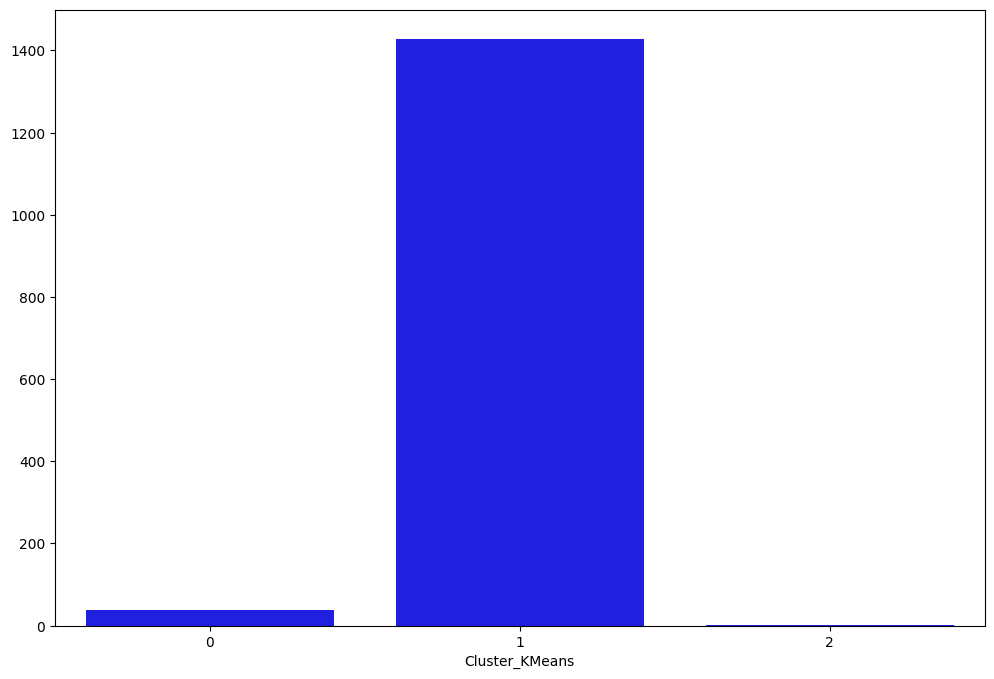

In [20]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

## 5. Graphical Visualization

C:\Users\usuario\AppData\Local\Temp\ipykernel_9388\3706655747.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


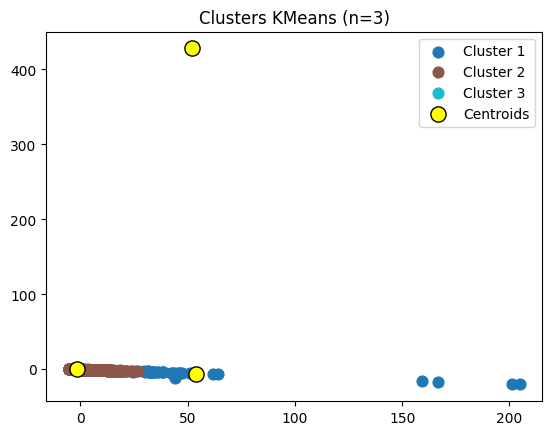

In [21]:
n_clusters=3

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
centroids_pca = pca.transform(kmeans_clusters.cluster_centers_)

colors = plt.cm.get_cmap('tab10', n_clusters)
for i in range(n_clusters):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], 
                s=60, marker='o', color=colors(i), label=f'Cluster {i+1}')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            s=120, c='yellow', edgecolor='black', marker='o', label='Centroids')
plt.title(f'Clusters KMeans (n={n_clusters})')
plt.legend()
plt.show()

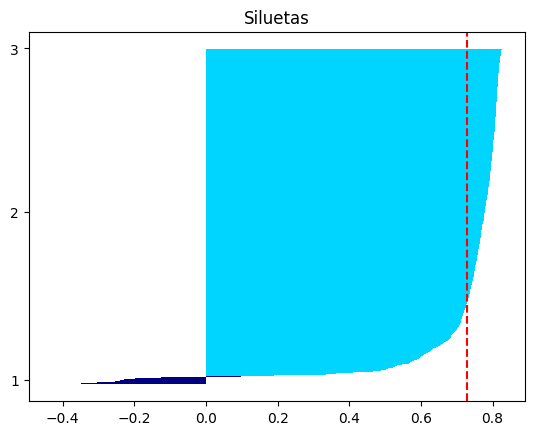

In [22]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, labels, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels+1)
plt.title("Siluetas")
plt.show()

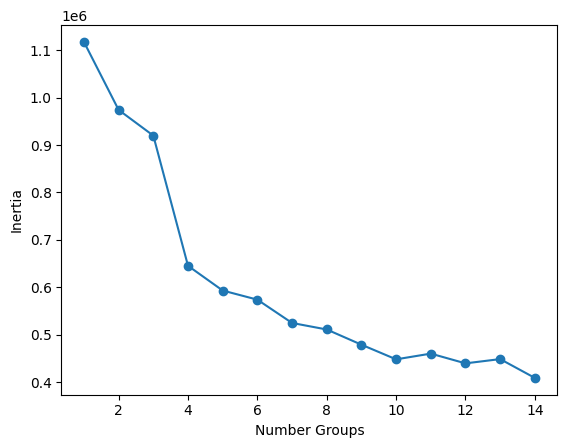

In [23]:
inertia = []
for i in range(1, 15):
    km = KMeans(n_clusters=i)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(range(1,15), inertia, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Inertia")
plt.show()

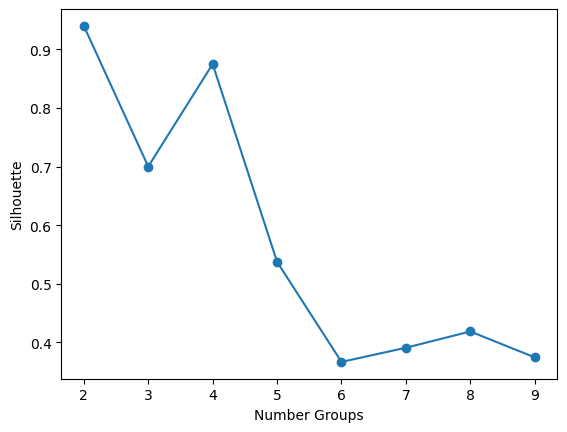

In [24]:
silhouette = []
for i in range(2, 10):
    km = KMeans(n_clusters=i)
    km.fit(X)
    silhouette.append(silhouette_score(X, km.labels_))

plt.plot(range(2,10), silhouette, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Silhouette")
plt.show()

## 6. Embeddings Model

In [25]:
def get_email_embeddings(df_emails):
    texts = (
        df_emails["sender"].astype(str) + " " +
        df_emails["receiver"].astype(str) + " " +
        df_emails["subject"].astype(str) + " " +
        df_emails["body"].astype(str) + " " +
        df_emails["urls"].astype(str)
    )
    embeddings = np.array([nlp(text).vector for text in texts])
    return embeddings

In [26]:
clean_text(df_emails)

Y = get_email_embeddings(df_emails)
print(Y.shape)

(1467, 96)


In [27]:
kmeans_clusters_v2 = KMeans(n_clusters=3)
kmeans_clusters_v2.fit(Y)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [28]:
labels = kmeans_clusters_v2.labels_
print(labels)

[0 2 0 ... 0 0 0]


<Axes: xlabel='Cluster_KMeans'>

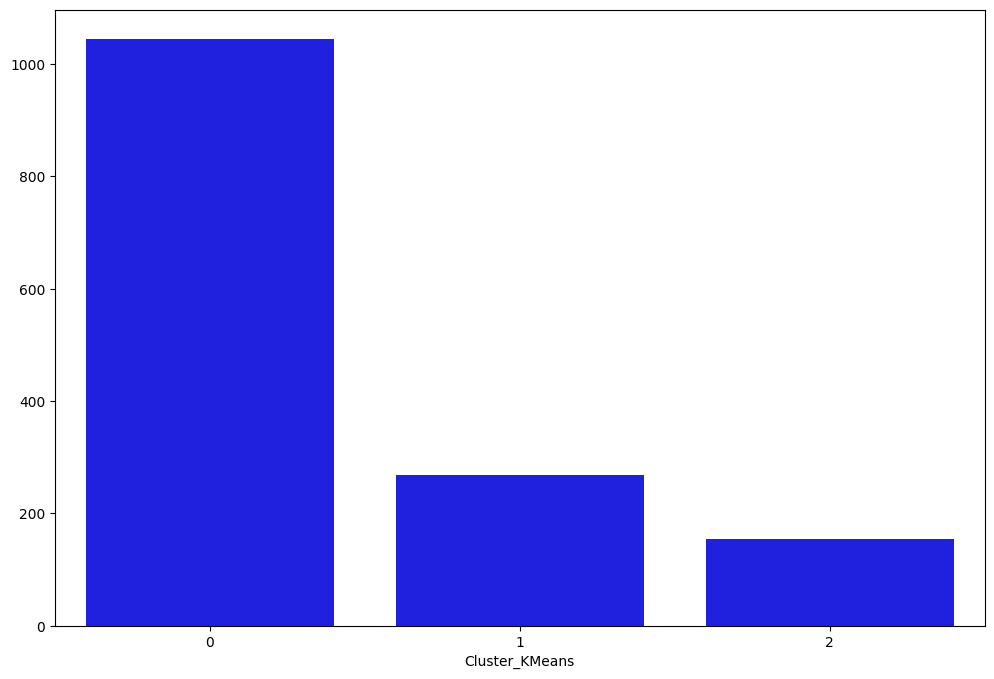

In [29]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

## 7. Embeddings Graphical Visualization

C:\Users\usuario\AppData\Local\Temp\ipykernel_9388\1897738182.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


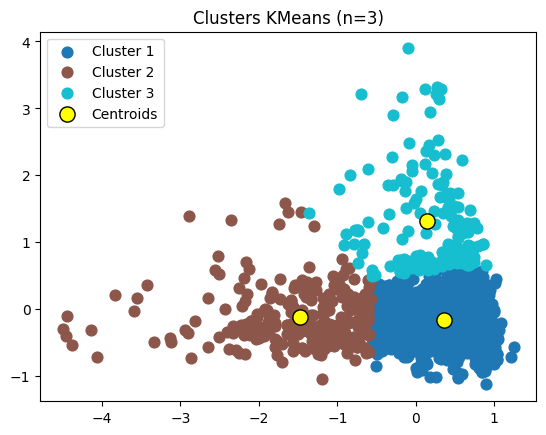

In [30]:
n_clusters = 3

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Y)
centroids_pca = pca.transform(kmeans_clusters_v2.cluster_centers_)

colors = plt.cm.get_cmap('tab10', n_clusters)
for i in range(n_clusters):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1],
                s=60, marker='o', color=colors(i), label=f'Cluster {i+1}')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            s=120, c='yellow', edgecolor='black', marker='o', label='Centroids')
plt.title(f'Clusters KMeans (n={n_clusters})')
plt.legend()
plt.show()

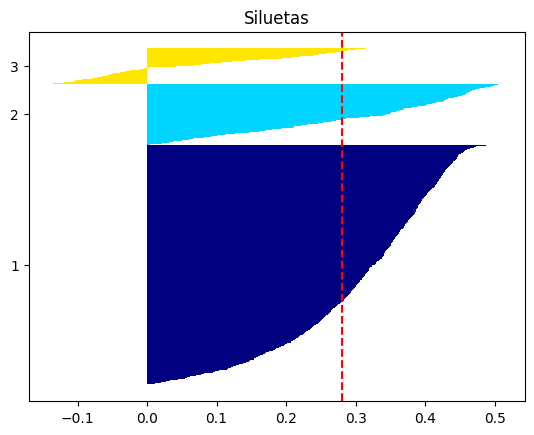

In [31]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(Y, labels, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels+1)
plt.title("Siluetas")
plt.show()

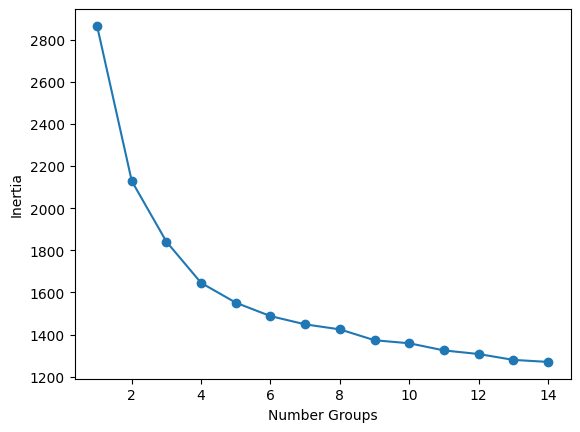

In [32]:
inertia = []
for i in range(1, 15):
    km = KMeans(n_clusters=i)
    km.fit(Y)
    inertia.append(km.inertia_)

plt.plot(range(1,15), inertia, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Inertia")
plt.show()

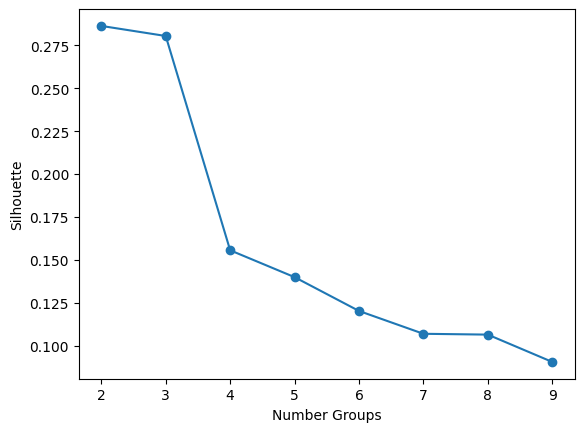

In [33]:
silhouette = []
for i in range(2, 10):
    km = KMeans(n_clusters=i)
    km.fit(Y)
    silhouette.append(silhouette_score(Y, km.labels_))

plt.plot(range(2,10), silhouette, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Silhouette")
plt.show()

## Execution Times

### Aprox 3 Minutes

### Text Processing (BoW & Embeddings) Most Demanding Tasks - 45 sec each